# **Neural style Transfer**
*Implementation of [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) created by Gatys et al. (2015)*

<br>
Neural style transfer is a technique in computer vision that combines the content of one image with the style of another image to create a new, generated image. It's based on the idea of using a deep neural network to extract and transfer the style information from a style reference image to a content image.

Using a pre-trained VGG19 network is a common implementation of the neural style transfer algorithm. VGG19 is a convolutional neural network architecture that was trained on the ImageNet dataset for image classification. 
The VGG19 network is used as a feature extractor to extract the content and style representations of the input images.

The process involves defining a loss function that measures the difference between the generated image and both the content image and the style reference image. The generated image is then optimized using stochastic gradient descent to minimize this loss and generate a final image that blends the content and style of the input images.

<br>
<p align="center">
<img src="https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/613ebfc73d78bd3ecbe775c3_neural-style-transfer-model-architecture.png" alt= “” width=40% height=20%  >
<p align="center">
https://www.v7labs.com/blog/neural-style-transfer
<p align="left">

<br>


- The content representation is obtained by passing the content image through the VGG19 network and keeping the activations of one of the layers which is considered to represent the content information. 
- The style representation is obtained in a similar way, but instead of using the activations of a single layer, several layers are selected to capture the style information and measure it through the Gram matrix of the activations.

- Finally, the generated image is optimized using gradient descent to minimize the difference between the content and style representations of the generated image and the content and style reference images. The generated image is updated iteratively, and after a sufficient number of iterations, a final image is obtained that blends the content and style of the input images.
<br>
<br>
___
### The goal of this project is to transform an image into a painting project by assigning it a brush painting style.
___



### In VGG19, 
the commonly selected style layers are the following intermediate layers: Conv1_1, Conv2_1, Conv3_1, Conv4_1, Conv5_1. 
These layers have been tested through the train with the next set of layers:
Conv1_2, Conv2_2, Conv3_3, Conv4_3, Conv5_1.

The final style loss has been computed on the second set of layers which in this particular proyect have shown better results.

As for the content layer, Conv5_1 is the selection. 
Conv2_2 and Conv5_2 have also been trained but were finally discarded.


In [1]:
import tensorflow as tf
import numpy as np
import cv2

import pandas as pd
import matplotlib.pyplot as plt

In [2]:

from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
path_main='/content/drive/MyDrive/TFM/06_transfer_style/'
path_style = path_main + 'style/'
path_content = path_main + 'content/'
path_output = path_main + 'output/'
path_model = path_main + 'models/'


In [4]:
!ls -l '/content/drive/MyDrive/TFM/06_transfer_style/style/'

total 6208
-rw------- 1 root root  119636 Feb  5 13:25 bursh_Strokes_orange_blue.jpg
-rw------- 1 root root  415174 Feb  5 13:45 color_cristal.png
-rw------- 1 root root 2366130 Feb  1 21:58 paint1.jpg
-rw------- 1 root root 2238746 Feb  1 21:58 paint2.jpg
-rw------- 1 root root  326511 Feb  8 06:09 paint3.jpg
-rw------- 1 root root   32192 Feb  5 13:22 pattern1.jpg
-rw------- 1 root root  182384 Feb  4 14:39 starry_night.jpg
-rw------- 1 root root  673824 Feb  5 13:21 wide_strokes2.png


In [5]:
"""
STYLE_IMAGE_URL = path_style + 'pattern1.jpg' #BETA = 0.05 - strong pattern
STYLE_IMAGE_URL = path_style + 'starry_night.jpg'
STYLE_IMAGE_URL = path_style + 'color_cristal.png'
STYLE_IMAGE_URL = path_style + 'wide_strokes2.png'
STYLE_IMAGE_URL = path_style + 'bursh_Strokes_orange_blue.jpg'
STYLE_IMAGE_URL = path_style + 'paint3.jpg'
"""
STYLE_IMAGE_URL = path_style + 'paint1.jpg'


"""
CONTENT_IMAGE_URL= path_content + '000000000785.jpg'
CONTENT_IMAGE_URL= path_content + '000000002473.jpg'
CONTENT_IMAGE_URL= path_content + '000000001296.jpg'
CONTENT_IMAGE_URL= path_content + '000000000285.jpg'
"""
CONTENT_IMAGE_URL = path_content + 'puppy.jpg'


file_name_with_extension = STYLE_IMAGE_URL.split("/")[-1]
style_name, extension = file_name_with_extension.split(".")

file_name_with_extension = CONTENT_IMAGE_URL.split("/")[-1]
image_name, extension = file_name_with_extension.split(".")


In [6]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[0], shape[1])
  offset_y = max(shape[0] - shape[1], 0) // 2
  offset_x = max(shape[1] - shape[0], 0) // 2
  crop_img = image[offset_y:offset_y+new_shape, offset_x:offset_x+new_shape]  
  return crop_img

def adjust_height_width(CONTENT_IMAGE_URL):
    
  im= cv2.imread(CONTENT_IMAGE_URL)
  
  max_shape=np.max(im.shape) 
  factor= 224/max_shape

  IMG_HEIGHT= int(im.shape[0]*factor)
  IMG_WIDTH= int(im.shape[1]*factor)

  return IMG_HEIGHT, IMG_WIDTH


def load_image(url, width, height, color_mode):
    image = cv2.imread(url)
    image = crop_center(image)
    image = cv2.resize(image, (height, width))
    
    print(image.shape, "\n")
    if cv2_imshow:
        cv2_imshow(image)
    else:
        cv2.imshow(image)

    image = cv2.cvtColor(image, color_mode)

    image = np.reshape(image, ((1,) + image.shape))
    image = tf.Variable(tf.image.convert_image_dtype(image, tf.float32)) 
    

    return image


Content image:
(400, 400, 3) 



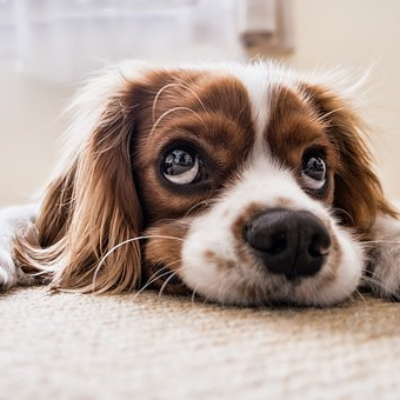


Style image:
(400, 400, 3) 



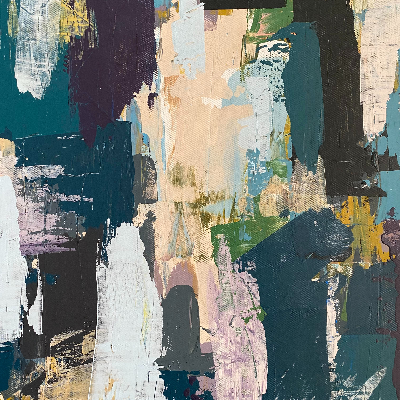

In [7]:
#IMG_HEIGHT, IMG_WIDTH = adjust_height_width(CONTENT_IMAGE_URL)
IMG_HEIGHT, IMG_WIDTH=400,400
COLOR_CHANNELS = 3


print("\nContent image:")
content_image = load_image(CONTENT_IMAGE_URL, IMG_WIDTH, IMG_HEIGHT, cv2.COLOR_BGR2RGB) 

print("\nStyle image:")
style_image = load_image(STYLE_IMAGE_URL, IMG_WIDTH, IMG_HEIGHT, cv2.COLOR_BGR2RGB)

# in a dedicated notebook, a heatmap of the style image layers is produced in orther to take decisions on the weights for each layer

#Evaluating the Style filters in the CONV layers for the model VGG19.

Observation of the filters for each layer in order to help to the decision on the weights to apply.
It seems layers block2_conv2 and block3_conv3 do keep most of the texture of the brush strokes so those layers will have a higher weight.


1/1 [==============================] - 9s 9s/step
layer: 1


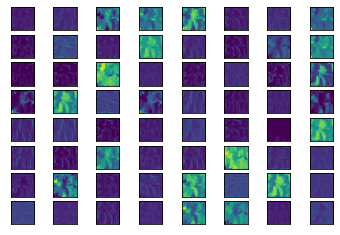

layer: 2


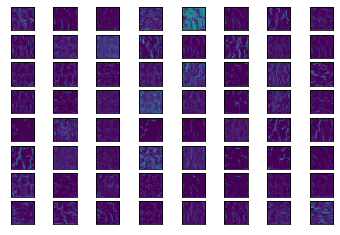

layer: 3


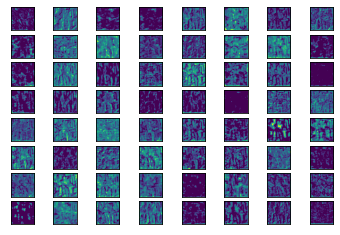

layer: 4


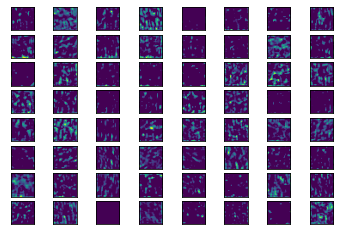

layer: 5


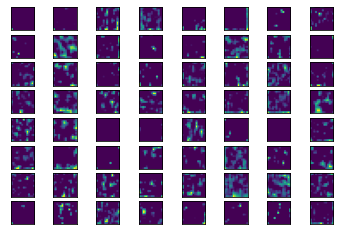

In [8]:
from keras.applications import VGG19
from keras.preprocessing import image
from keras.utils import load_img
from keras.utils import img_to_array
from keras import backend as K
from keras.models import Model

# Load the pre-trained VGG19 model
model_vgg = VGG19(weights='imagenet')

# Load the image and preprocess it
img = load_img(STYLE_IMAGE_URL, target_size=(224, 224))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Define the layers you want to extract the activations from   
layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv1']
#layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
layers = [model_vgg.get_layer(name).output for name in layer_names]

# Create a new model that outputs the activations of the specified layers
feature_extractor =Model(inputs=model_vgg.input, outputs=layers)

# Get the activations of the specified layers
activations = feature_extractor.predict(img_tensor)


#show the filters of the layers to extract for style image
square = 8
for n,fmap in enumerate(activations):
  # plot all 64 maps in an 8x8 squares
  ix = 1
  print('layer:',n+1)
  for _ in range(square):    
    for _ in range(square):
      # specify subplot and turn of axis
      ax = plt.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      plt.imshow(fmap[0, :, :, ix-1]) #, cmap='gray'
      ix += 1
  # show the figure
  plt.show()

In [9]:
def add_noise(image, noise_range):
    noise = tf.random.uniform(image.shape, -noise_range, noise_range)

    image = tf.add(image, noise)
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    image = tf.Variable(tf.image.convert_image_dtype(image, tf.float32))

    return image

Definition of the weights for the style layers and function to load the model VGG19
___

In [10]:
weight1,weight2,weight3,weight4,weight5= 0.1, 0.3, 0.4, 0.1, 0.1
#weight1,weight2,weight3,weight4,weight5= 0.1, 0.3, 0.1, 0.2, 0.3

def load_VGG19(contentlayer='block5_conv1'):

    STYLE_LAYERS = [
        ('block1_conv2', weight1),
        ('block2_conv2', weight2),
        ('block3_conv3', weight3),
        ('block4_conv3', weight4),
        ('block5_conv1', weight5)
    ]

    model = tf.keras.applications.VGG19(
        include_top = False,
        input_shape = (IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS),
        weights = 'imagenet'
        )

    CONTENT_LAYER = [(contentlayer, 1)]  #default -- block5_conv2 

    model.trainable = False

    return model, STYLE_LAYERS, CONTENT_LAYER

Define the model, where the last layers of VGG19 have been removed. Those layers (dense + softmax activation) are especific of classification models.

In [11]:
model, STYLE_LAYERS, CONTENT_LAYER = load_VGG19('block5_conv1')  #'block2_conv2'

outputs = [model.get_layer(layer[0]).output for layer in STYLE_LAYERS + CONTENT_LAYER]

model = tf.keras.Model([model.input], outputs)

80134624/80134624 [==============================] - 0s 0us/step


In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 400, 400, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 400, 400, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 200, 200, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 200, 200, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 200, 200, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 100, 100, 128)     0   

### **Content cost function:**

$J_{content}(C,G)= \dfrac{1}{4 \times n_H \times n_W \times n_C}\sum (a^{(C)} - a^{(G)})^2$

* $n_H, n_W, n_C$ are dimentions of hidden layer.
* $a$ is the hidden layer activation selected as content layer.



In [13]:
def compute_content_cost(content_output, generated_output):
    a_C = content_output[-1]
    a_G = generated_output[-1]

    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H * n_W, n_C])

    J_content =  tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4.0 * n_H * n_W * n_C)
    
    return J_content


### **Single layer style cost function:**

$J_{style}^{[l]}(S,G)= \dfrac{1}{4 \times n_C^2 \times (n_H \times n_W)^2}\sum_{i=1}^{n_C}\sum_{j=1}^{n_C} (G_{gram_{i,j}}^{(S)} - G_{gram_{i,j}}^{(G)})^2$

* $G_{gram}^{(S)}$ is Gram matrix of style image.

* $G_{gram}^{(G)}$ is Gram matrix of generated image.

**Gram matrix:**

$G_{gram} = V.V^T$

*We use it only twice so we can but don't have to create an additional function.*


In [14]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA

#Gram_Matrix = (A * A.T) / (ColorChanel * Height * Width)


def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, shape=[-1, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, shape=[-1, n_C]))
    
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)
    
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4.0 *(( n_H * n_W * n_C)**2))
       
    return J_style_layer

### **Style cost function:**
$J_{style}(S,G)=∑_l λ^{[l]}J_{style}^{[l]}(S,G)$


In [15]:
def compute_style_cost(style_image_output, generated_image_output, style_layers=STYLE_LAYERS): #style_layers=STYLE_LAYERS
    J_style = 0

    a_S = style_image_output[1:]
    a_G = generated_image_output[1:]

    for i, weight in zip(range(len(a_S)), style_layers):  
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
        J_style += weight[1] * J_style_layer

    return J_style


### **Total cost function:**
$J(G)=\alpha J_{content}(C,G) + \beta J_{style}(S,G)$

$\alpha$ and $\beta$ parameters describes learning proportion of content related to applied style.

In [16]:
def total_cost(J_content, J_style, alpha, beta):
    t_cost = alpha * J_content + beta * J_style
    return t_cost

In [17]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]

    return cv2.cvtColor(tensor, cv2.COLOR_BGR2RGB)


In [18]:
def resize_image(image, width, height):
    if max(width,height) > 500:
      result=cv2.resize(image, (width//2, height//2), interpolation = cv2.INTER_CUBIC)
    else:
      result=image
    return result

Generating a data frame where to load the information on the training results.

In [19]:
def generate_df_loss(loss_epoch, EPOCHS, LEARNING_RATE,ALPHA, BETA, ADD_NOISE,NOISE_RANGE):

  df_model = pd.DataFrame(loss_epoch,columns=["Loss"])  
  df_model['image_content'] = image_name   
  df_model['image_style'] = style_name  
  df_model['epoch_iter'] = df_model.index
  df_model['epochs'] = EPOCHS
  df_model['learning_rate'] = LEARNING_RATE
  df_model['alpha'] = ALPHA
  df_model['beta'] = BETA
  df_model['add_noise'] = ADD_NOISE
  df_model['noise_range'] = NOISE_RANGE   
  df_model['style_layer1_w'] = weight1 
  df_model['style_layer2_w'] = weight2 
  df_model['style_layer3_w'] = weight3 
  df_model['style_layer4_w'] = weight4 
  df_model['style_layer5_w'] = weight5 
  
  return df_model

In [20]:
def plot_comparison(img_result):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 8), sharex=True, sharey=True)

    ax1.imshow(content_image[0,:,:,:], cmap=plt.cm.gray)
    ax1.set_title('original image') 
    ax1.axis('off')

    ax2.imshow(img_result, cmap=plt.cm.gray)
    ax2.set_title('training result')
    ax2.axis('off')

    ax3.imshow(style_image[0,:,:,:], cmap=plt.cm.gray)
    ax3.set_title('style image')
    ax3.axis('off')
    

In [21]:
def train_model(LEARNING_RATE,ALPHA,BETA,EPOCHS,EPOCHS_PER_IMAGE_OUTPUT,ADD_NOISE,NOISE_RANGE,generated_image):  #TOTAL_VARIATION_WEIGHT excluded
   
    noise_id=0
    if ADD_NOISE:
        generated_image = add_noise(generated_image, NOISE_RANGE)
        noise_id= NOISE_RANGE             

    #lst loss 
    lst_loss=[]

    for i in range(EPOCHS):
        loss=train_step(generated_image, ALPHA, BETA)
        loss_fmt="{:.3f}".format(loss)
        
        #lst loss 
        lst_loss.append(np.round(loss,3))

        if i % EPOCHS_PER_IMAGE_OUTPUT == 0:
            print(f"\n Epoch {i} \n{loss_fmt} ")
            image = tensor_to_image(generated_image)           

            if cv2_imshow:
                cv2_imshow(resize_image(image,IMG_WIDTH, IMG_HEIGHT))
            else:
                cv2.imshow(resize_image(image,IMG_WIDTH, IMG_HEIGHT))

            cv2.imwrite(path_output +  f"Style_{style_name}_image_{image_name}_lr_{LEARNING_RATE}_wcontent_{ALPHA}_wstyle_{BETA}_noise_{noise_id}_TrainIter_{i}_loss_{loss_fmt}.jpg", image)

        if  i == EPOCHS - 1:
            image = tensor_to_image(generated_image)   
            print(f"\n Epoch {i} \n{loss_fmt} ")

            imagergb=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plot_comparison(imagergb)

            cv2.imwrite(path_output +  f"Result_Style_{style_name}_image_{image_name}_lr_{LEARNING_RATE}_wcontent_{ALPHA}_wstyle_{BETA}_noise_{noise_id}_TrainIter_{i}_loss_{loss_fmt}_epochs_{EPOCHS}.jpg", image)    

    df_train=generate_df_loss(lst_loss, EPOCHS, LEARNING_RATE,ALPHA, BETA, ADD_NOISE,NOISE_RANGE)


    #save model
    #model.save(path_model + "vgg19_model.h5")


    return lst_loss,df_train

In [25]:

@tf.function()
def train_step(generated_image, alpha, beta):

    with tf.GradientTape() as tape:

        a_G = model(generated_image)

        J_style = compute_style_cost(a_S, a_G)
        J_content = compute_content_cost(a_C, a_G)

        J = total_cost(J_content, J_style, alpha, beta)
        #J += TOTAL_VARIATION_WEIGHT * tf.image.total_variation(generated_image)   #it should reduce the noise in the generated image
        
        
    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))

    return J


LEARNING_RATE = 0.03 #0.05
ALPHA = 1 #50
BETA =  0.3 #10   0.1 t 0.5 (typical values where alpha =1)
EPOCHS = 2000 #1000
EPOCHS_PER_IMAGE_OUTPUT = EPOCHS//5 #300
#TOTAL_VARIATION_WEIGHT=30.


ADD_NOISE = True
NOISE_RANGE = 0.2

generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
model.summary()

a_C = model(content_image)
a_S = model(style_image)
a_G = model(generated_image)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
#generated_image = None

loss_epoch, df_loss =train_model(LEARNING_RATE,ALPHA,BETA,EPOCHS,EPOCHS_PER_IMAGE_OUTPUT,ADD_NOISE,NOISE_RANGE,generated_image)


# add the results to df for later info recovery
if 'df_training' in globals():
    df_training= df_training.append(df_loss, ignore_index=True)
else:
    df_training= df_loss


Output hidden; open in https://colab.research.google.com to view.

In [26]:
#recording the training session per day
datime='20230210_22'
df_training.to_csv(path_output + datime + 'df_training.csv', index=False)

# LOSS CURVE

loss per epoch graph and detail on the last iterations in order to know if the model is still lowering the loss.

,Loss,image_content,image_style,epoch_iter,epochs,learning_rate,alpha,beta,add_noise,noise_range,style_layer1_w,style_layer2_w,style_layer3_w,style_layer4_w,style_layer5_w
1682,0.297,puppy,paint1,1682,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1683,0.297,puppy,paint1,1683,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1684,0.297,puppy,paint1,1684,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1686,0.298,puppy,paint1,1686,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1655,0.298,puppy,paint1,1655,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1656,0.298,puppy,paint1,1656,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1668,0.298,puppy,paint1,1668,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1680,0.298,puppy,paint1,1680,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1681,0.298,puppy,paint1,1681,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1685,0.298,puppy,paint1,1685,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1


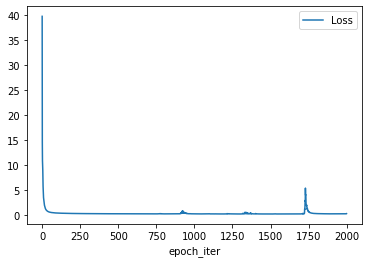

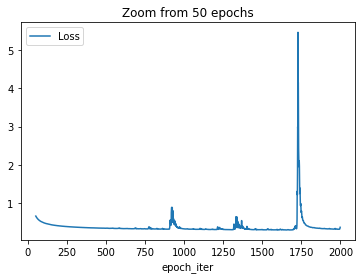

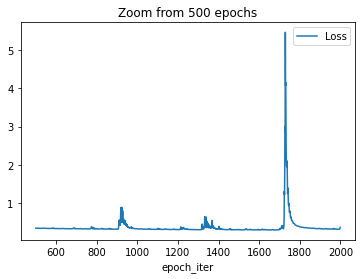

In [27]:
df_loss.plot(x= "epoch_iter",y=["Loss"])
df_loss[50:].plot(x= "epoch_iter",y=["Loss"],title='Zoom from 50 epochs')
df_loss[500:].plot(x= "epoch_iter",y=["Loss"],title='Zoom from 500 epochs')

df_loss.sort_values('Loss',ascending=True).head(10)

,Loss,image_content,image_style,epoch_iter,epochs,learning_rate,alpha,beta,add_noise,noise_range,style_layer1_w,style_layer2_w,style_layer3_w,style_layer4_w,style_layer5_w
190,0.410,puppy,paint1,190,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
191,0.409,puppy,paint1,191,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
192,0.409,puppy,paint1,192,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
193,0.408,puppy,paint1,193,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
194,0.408,puppy,paint1,194,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
195,0.408,puppy,paint1,195,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
196,0.407,puppy,paint1,196,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
197,0.407,puppy,paint1,197,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
198,0.406,puppy,paint1,198,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
199,0.406,puppy,paint1,199,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1


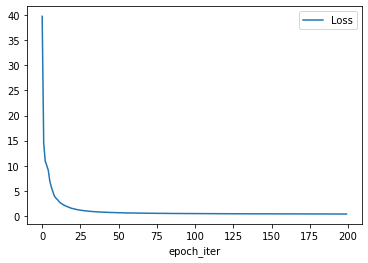

In [28]:
df_loss_100=df_loss.iloc[:200]
df_loss_100.plot(x= "epoch_iter",y=["Loss"])
df_loss_100.tail(10)


In [29]:
df_loss.tail(10)

,Loss,image_content,image_style,epoch_iter,epochs,learning_rate,alpha,beta,add_noise,noise_range,style_layer1_w,style_layer2_w,style_layer3_w,style_layer4_w,style_layer5_w
1990,0.317,puppy,paint1,1990,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1991,0.317,puppy,paint1,1991,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1992,0.317,puppy,paint1,1992,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1993,0.316,puppy,paint1,1993,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1994,0.317,puppy,paint1,1994,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1995,0.319,puppy,paint1,1995,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1996,0.323,puppy,paint1,1996,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1997,0.330,puppy,paint1,1997,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1998,0.344,puppy,paint1,1998,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1
1999,0.368,puppy,paint1,1999,2000,0.03,1,0.3,True,0.2,0.1,0.3,0.4,0.1,0.1


# **CONCLUSION**

Through some testing and parameters setings,the next combinations are kept as the best options to find the desired result;
### Option1
- Content layer: block2_conv2 /**block5_conv1**
-  Style layers and weights
  * block1_conv2, block2_conv2,block3_conv3,block4_conv3,block5_conv1     
  * 0.1,0.3,0.4,0.1,0.1

- Learning rate: 0.03
- Alpha: 1
- Beta: 0.3
- Noise: 0.6/ **0.2**

### Option2
- Content layer:block5_conv1/block2_conv2
-  Style layers and weights
  * block1_conv2, block2_conv2,block3_conv3,block4_conv3,block5_conv1     
  * 0.1,0.3,0.1,0.2,0.3

- Learning rate: 0.03
- Alpha: 1
- Beta: 0.1
- Noise: 0.4 /0.6






# FINAL SELECTION

**Option 1 with content layer: block5_conv1 and noise up to 0.2** 
The decision to choose this particular option was made based on the visual quality of the generated image, rather than on the results of the loss function, although those results have been taken in consideration. 